In [1]:
import numpy as np
from myplotstyle import plt, get_figsize

from easyquery import Query, QueryMaker
import SAGA
from SAGA import ObjectCuts as C
from SAGA import HostCuts as H

from SAGA.utils import calc_cdf
from astropy.table import join
from collections import defaultdict

In [2]:
print(SAGA.__version__)
saga = SAGA.QuickStart()

3.0.0
SAGA `shared_dir` set to /home/yymao/Dropbox/Work/SAGA
SAGA `local_dir`  set to /home/yymao/Documents/Work/Data/SAGA


In [3]:
base = H.paper3.filter(saga.object_catalog.load_combined_base_catalog())
nhosts = len(np.unique(base["HOSTID"]))
assert nhosts == 101

In [4]:
base = Query(C.sat_rcut, C.is_host | "p_sat_corrected > 0").filter(base)

In [5]:
hosts = saga.host_catalog.load(include_stats=True, query="paper3")
hosts = join(hosts, C.is_host.filter(base), "HOSTID", uniq_col_name="{col_name}{table_name}", table_names=["", "_base"])

In [6]:
def host_selection(*query, invert=False):
    host_ids = Query(*query).filter(hosts, "HOSTID")
    return QueryMaker.isin("HOSTID", host_ids, invert=invert), len(host_ids)

def select_host_quantiles(prop):
    ql, qm, qh = np.nanpercentile(hosts[prop], [25, 50, 75])
    return (
        host_selection(f"{prop} >= {qh}"),
        host_selection(f"{prop} >= {qm}", f"{prop} < {qh}"),
        host_selection(f"{prop} >= {ql}", f"{prop} < {qm}"),
        host_selection(f"{prop} < {ql}"),
    )

In [7]:
d = defaultdict(list)
for host in hosts["HOSTID"]:
    base1 = QueryMaker.equal("HOSTID", host).filter(base)
    d["HOSTID"].append(host)
    d["sat_gold_median_distance"].append(np.median(Query(C.sample_gold, C.is_sat).filter(base1, "RHOST_KPC")))

    sat_Mr = C.is_sat.filter(base1, "Mr")
    if len(sat_Mr) > 1:
        sat_Mr = np.sort(sat_Mr)
        gap = sat_Mr[1] - sat_Mr[0]
    else:
        gap = np.nan
    d["sat_gap"].append(gap)

hosts = join(hosts, d, "HOSTID")

/home/yymao/miniforge3/envs/mypy/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/yymao/miniforge3/envs/mypy/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [8]:
hosts["nuv_ssfr"] = hosts["nuv_sfr"] - hosts["log_sm"]

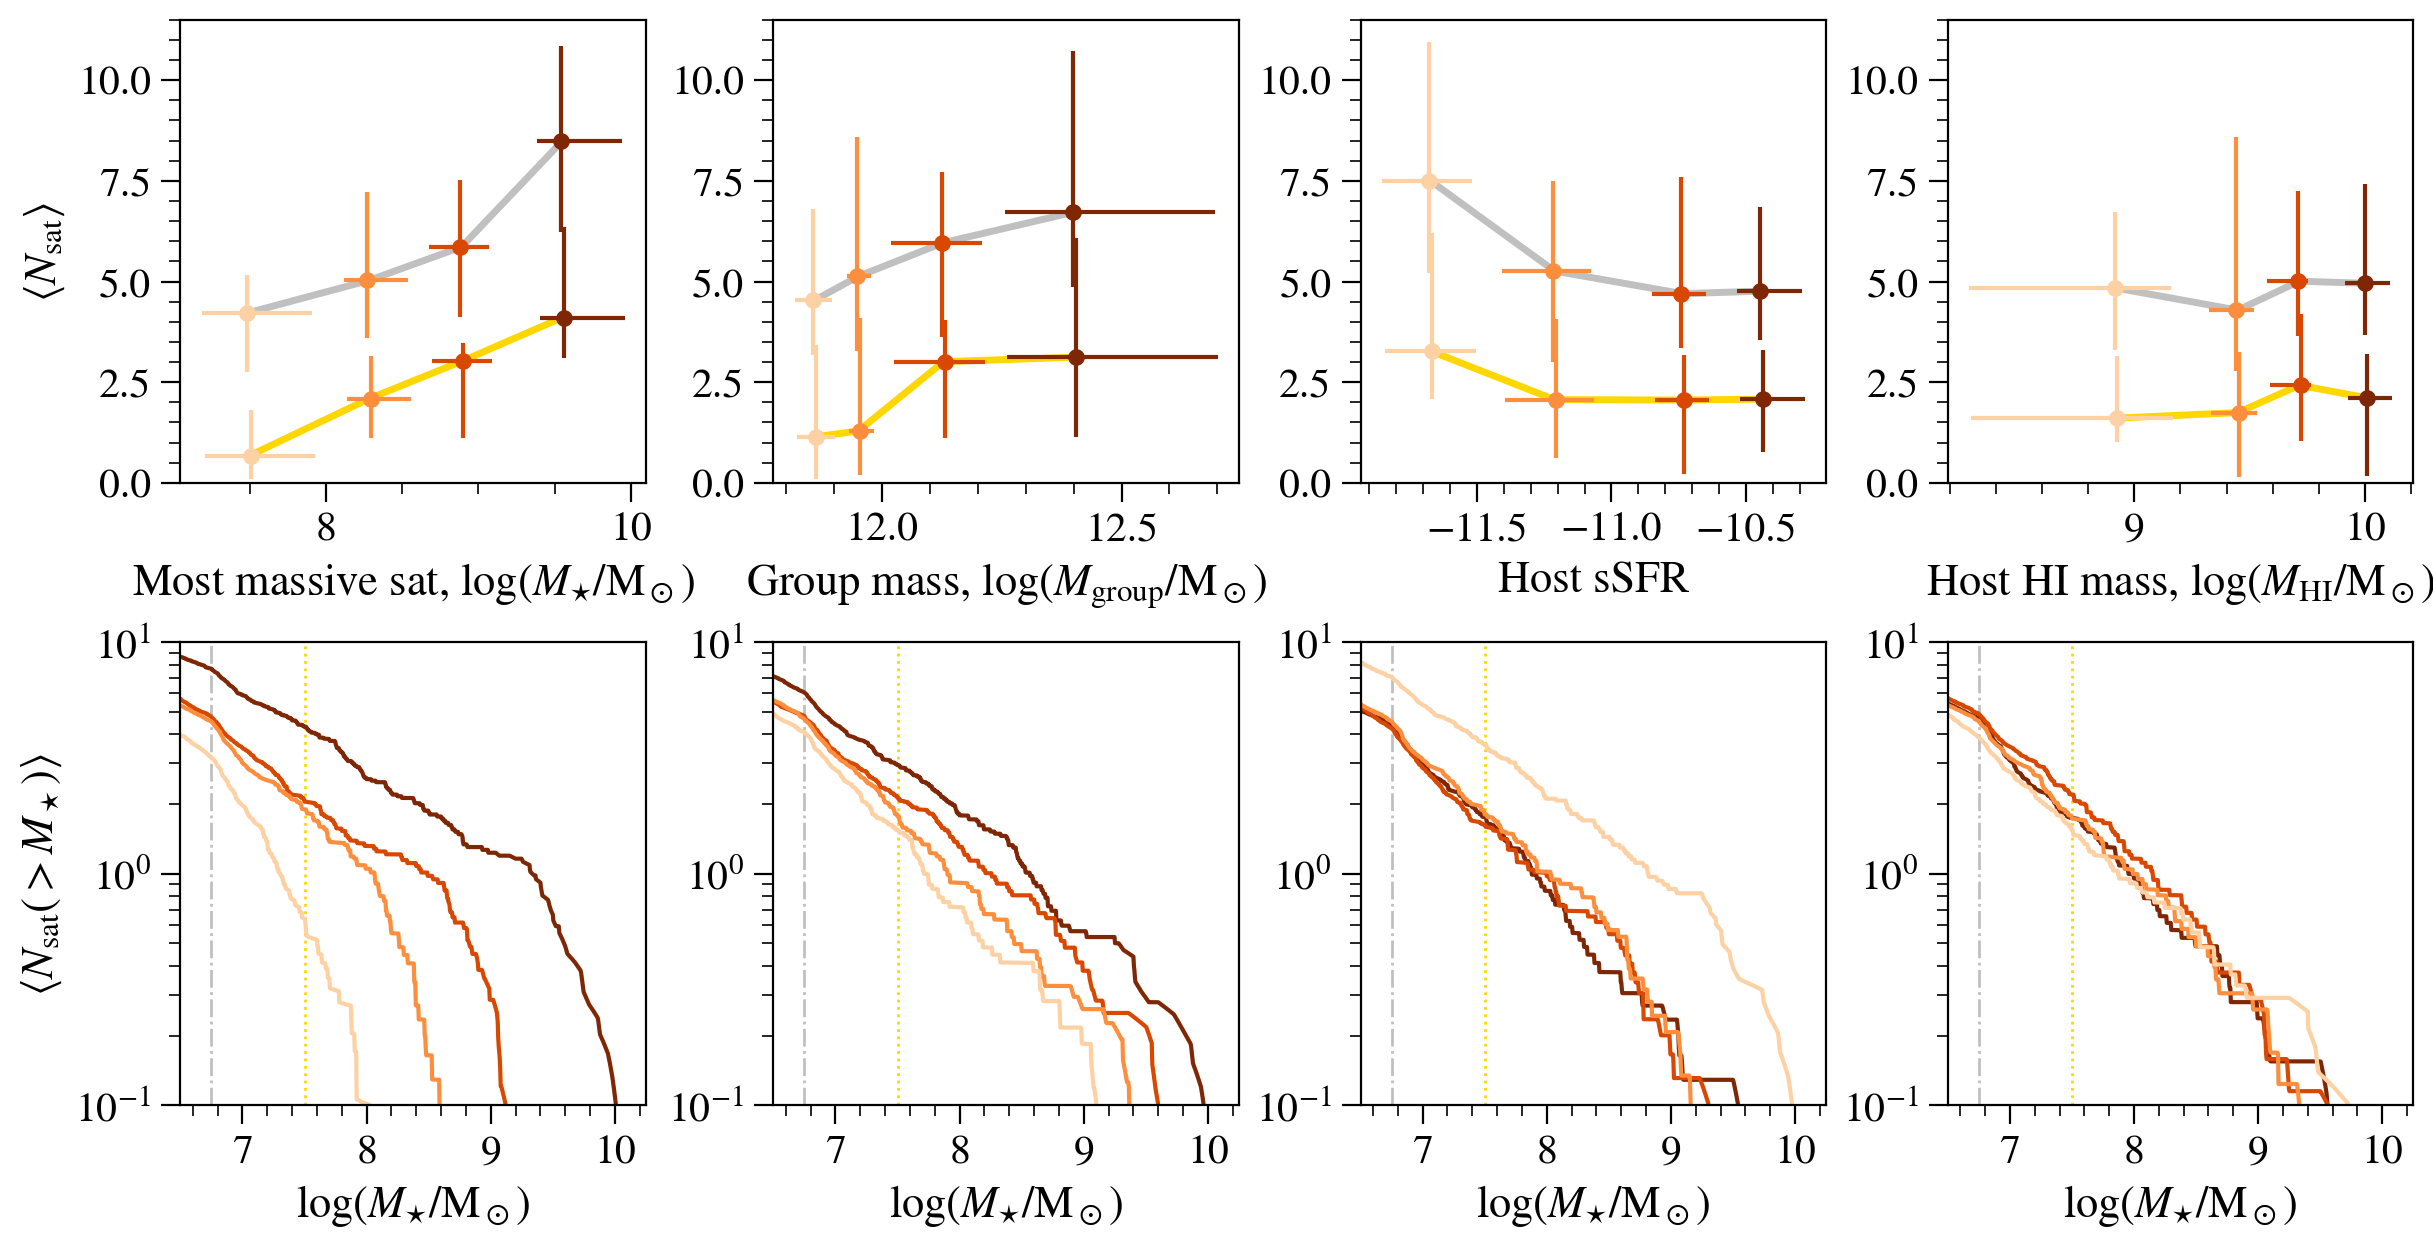

In [9]:
mbins = np.linspace(6.375, 10.875, 13)[1:]
x = 0.5 * (mbins[1:] + mbins[:-1])
mbins_diff = np.ediff1d(mbins)

x = cdf_bins = np.linspace(6.5, 10.5, 1001)

fig, ax = plt.subplots(2, 4, figsize=get_figsize(wide=True, ratio=2))

props = ["most_massive_sat", "M_HALO", "nuv_ssfr", "LOG_MHI"]
prop_labels = [
    r"Most massive sat, $\log ( M_{\star} / {\rm M}_\odot ) $",
    r"Group mass, $\log ( M_{{\rm group}} / {\rm M}_\odot ) $",
    r"Host sSFR",
    r"Host HI mass, $\log ( M_{\rm HI} / {\rm M}_\odot ) $",
    ]

for icol, (host_prop, prop_label) in enumerate(zip(props, prop_labels)):
    ax_top = ax[0, icol]
    ax_btm = ax[1, icol]
    X = []
    for i, (host_selector, nhosts) in enumerate(select_host_quantiles(host_prop)):

        t = Query(host_selector, ~C.is_host).filter(base)
        count = calc_cdf(-t["log_sm_phony"], -cdf_bins[::-1], weights=t["p_sat_corrected"])[::-1] * Query(f"log_sm_phony >= {cdf_bins[0]}").filter(t, "p_sat_corrected").sum() / nhosts
        #count = np.histogram(t["log_sm_phony"], mbins, weights=t["p_sat_corrected"])[0] / nhosts / mbins_diff

        color = plt.cm.Oranges_r(0.25*i)
        label = f"{100-(i+1)*25}–{100-i*25}%"
        ax_btm.plot(x, count, c=color)


        cols = [host_prop, "sats_gold", "sats_gold_silver"]
        hosts_this = host_selector.filter(hosts, cols)
        X.append([np.percentile(hosts_this[col], [16, 50, 84]) for col in cols])

    X = np.array(X)
    ax_top.plot(X[:,0,1], X[:,1,1], c="gold", lw=2.5)
    ax_top.plot(X[:,0,1], X[:,2,1], c="silver", lw=2.5)

    dx = (X[-1,0,1] - X[0,0,1]) * 0.01
    for j in [1, 2]:
        for i in range(4):
            ax_top.errorbar(
                [X[i,0,1] + (j-1.5)*dx], [X[i,j,1]],
                xerr=([X[i,0,1]-X[i,0,0]], [X[i,0,2]-X[i,0,1]]),
                yerr=([X[i,j,1]-X[i,j,0]], [X[i,j,2]-X[i,j,1]]),
                ls="", marker="o", color=plt.cm.Oranges_r(0.25*i), zorder=99
            )
    ax_top.set_ylim(0, 11.5)
    ax_top.set_xlabel(prop_label)

    ax_btm.axvline(7.5, lw=1, ls=":", color="gold", zorder=-1)
    ax_btm.axvline(6.75, lw=1, ls="-.",color="silver", zorder=-1)
    ax_btm.set_xlabel(r"$\log ( M_{\star} / {\rm M}_\odot )$")
    #ax_this.set_ylim(0, 7)
    ax_btm.set_xlim(6.5, 10.25)
    ax_btm.set_xticks([7,8,9,10])
    ax_btm.set_yscale("log")
    ax_btm.set_ylim(0.1, 10)

ax[0,0].set_ylabel(r"$\langle N_{\rm sat} \rangle $")
ax[1,0].set_ylabel(r"$\langle N_{\rm sat} (> M_\star) \rangle$")

plt.savefig("plots/smf_split.pdf")